In [1]:
import numpy as np
from dpyscf.utils import * 
from pyscf import gto, scf, dft
from ase.io import read, write 
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/gpfs/home/smdick/miniconda3/envs/torch/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['datetime']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [186]:
spins = np.load('../scripts/spin_square.npy')[:148]

In [187]:
openshell = np.where(spins[:,1] - 1 > 1e-2)[0]

In [188]:
openshell

array([  5,   6,   7,   8,  14,  19,  23,  34,  35,  37,  38,  49,  63,
        68,  76,  83,  84,  88,  94,  97, 105, 106, 107, 108, 110, 116,
       117, 121, 122, 126, 141])

In [189]:
atoms = read('../data/haunschild_g2/g2_97.traj',':')

In [190]:
for i,a in enumerate(atoms):
    atoms[i].info['openshell'] = False

In [191]:
for i in openshell:
    atoms[i].info['openshell'] = True

In [192]:
triplets = []
for a in atoms:
    if not a.info['openshell']: continue
    basis = '6-311G(3df,2p)'
    spin = 1
    pos = a.positions
    spec = a.get_chemical_symbols()
    mol_input = [[s, p] for s, p in zip(spec, pos)]
    try:
        mol = gto.M(atom=mol_input, basis=basis,spin=spin)
    except:
        triplets.append(a)

In [193]:
triplets

[Atoms(symbols='S2', pbc=False, calculator=SinglePointCalculator(...)),
 Atoms(symbols='OS', pbc=False, calculator=SinglePointCalculator(...)),
 Atoms(symbols='NH', pbc=False, calculator=SinglePointCalculator(...)),
 Atoms(symbols='SiH2', pbc=False, calculator=SinglePointCalculator(...)),
 Atoms(symbols='CH2', pbc=False, calculator=SinglePointCalculator(...)),
 Atoms(symbols='CH2', pbc=False, calculator=SinglePointCalculator(...)),
 Atoms(symbols='Si2', pbc=False, calculator=SinglePointCalculator(...)),
 Atoms(symbols='O2', pbc=False, calculator=SinglePointCalculator(...))]

In [195]:
write('../data/haunschild_g2/g2_97.traj',atoms)

In [182]:
atoms = read('../data/haunschild_g2/g2_97.traj',':')
{i:a for i,a in enumerate(atoms) if str(a.symbols) == 'Si2'}

{110: Atoms(symbols='Si2', pbc=False, calculator=SinglePointCalculator(...))}

In [2]:
atoms = read('../data/haunschild_g2/g2_97.traj',':')[106]

In [5]:
atoms = read('../data/haunschild_scan_extended.traj',':')[1]

In [6]:
from pylibnxc.pyscf import RKS

In [10]:
basis = '6-311++G(3df,2pd)'
spin = 0
pos = atoms.positions
spec = atoms.get_chemical_symbols()
mol_input = [[s, p] for s, p in zip(spec, pos)]
mol = gto.M(atom=mol_input, basis=basis,spin=spin)
mol.verbose = 4
mf = RKS(mol, nxc='MGGA_X_SCAN, MGGA_C_SCAN')
# mf.xc = 'PBE'
mf.grids.level = 5
mf.kernel()



******** <class 'pyscf.dft.rks.RKS'> ********
method = RKS-RHF
initial guess = minao
damping factor = 0
level_shift factor = 0
DIIS = <class 'pyscf.scf.diis.CDIIS'>
diis_start_cycle = 1
diis_space = 8
SCF conv_tol = 1e-09
SCF conv_tol_grad = None
SCF max_cycles = 50
direct_scf = True
direct_scf_tol = 1e-13
chkfile to save SCF result = /gpfs/home/smdick/dpyscf/notebooks/tmp_pitirv3
max_memory 4000 MB (current use 411 MB)
XC functionals = MGGA_X_SCAN, MGGA_C_SCAN
small_rho_cutoff = 1e-07
radial grids: 
    Treutler-Ahlrichs [JCP 102, 346 (1995); DOI:10.1063/1.469408] (M4) radial grids
    
becke partition: Becke, JCP 88, 2547 (1988); DOI:10.1063/1.454033
pruning grids: <function nwchem_prune at 0x2aaaebb87280>
grids dens level: 5
symmetrized grids: False
atomic radii adjust function: <function treutler_atomic_radii_adjust at 0x2aaaebb87160>
Set gradient conv threshold to 3.16228e-05
tot grids = 86316
init E= -109.662284732142
  HOMO = -0.396373525167768  LUMO = -0.0524463847925803
cycl

-109.51777372972985

In [55]:
basis = '6-311G(3df,2p)'
spin = 1
method = dft.UKS
pos = atoms.positions
spec = atoms.get_chemical_symbols()
mol_input = [[s, p] for s, p in zip(spec, pos)]
mol = gto.M(atom=mol_input, basis=basis,spin=spin)
mf = scf.UHF(mol)
mf.kernel()

converged SCF energy = -14.9706027555009  <S^2> = 3.750007  2S+1 = 4.0000035


-14.970602755500932

In [183]:
spins = []
spins.append(mf.spin_square())

In [185]:
spins

[(0, 1)]

In [158]:
mol.nao_cart()

30

In [159]:
idx = np.array([0, 1, 2, 5, 6, 7, 8, 11])
X, Y = np.meshgrid(idx, idx)

In [160]:
def plot_pot(v, mol = None):
    figsize(12,12)
    if mol is not None:
        labels = mol.ao_labels()
        xticks(np.arange(len(labels)),labels,rotation='-90')
        yticks(np.arange(len(labels)),labels)
    imshow(v)
    

In [161]:
vxc = mf.get_veff() - mf.get_j()

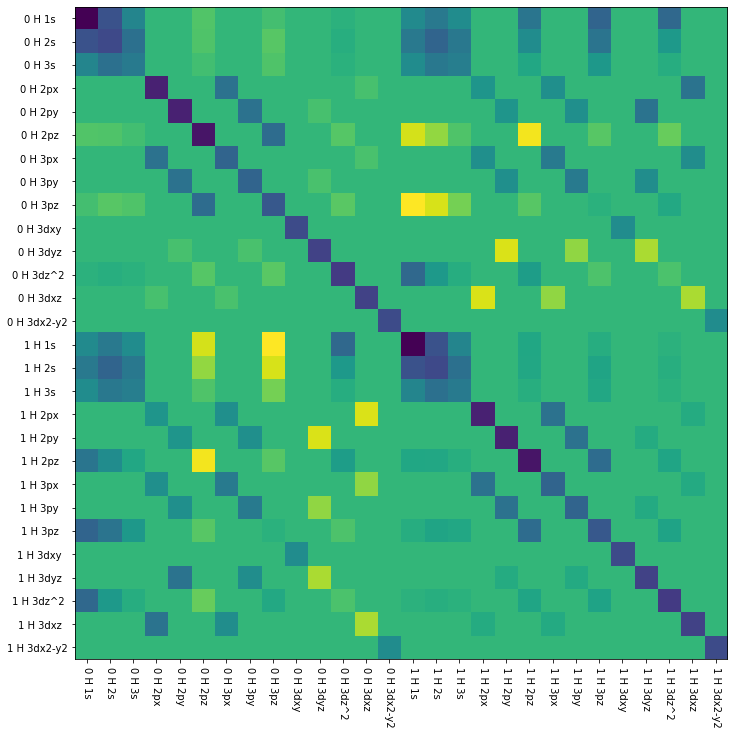

In [162]:

plot_pot(vxc, mol)

In [163]:
np.diag(vxc)

array([-0.5059242 , -0.3361181 , -0.19018761, -0.43450337, -0.43450337,
       -0.46186172, -0.25849422, -0.25849422, -0.29527071, -0.33223971,
       -0.35542668, -0.37530388, -0.35542668, -0.33223971, -0.5059242 ,
       -0.3361181 , -0.19018761, -0.43450337, -0.43450337, -0.46186172,
       -0.25849422, -0.25849422, -0.29527071, -0.33223971, -0.35542668,
       -0.37530388, -0.35542668, -0.33223971])

In [170]:
ao_eval = mf._numint.eval_ao(mol,mf.grids.coords,deriv=0)

In [171]:
rho = mf._numint.get_rho(mol, mf.make_rdm1(),mf.grids)

In [172]:
ao_eval.shape

(306310, 28)

In [176]:
np.diag(np.einsum('i,ij,ik',np.ones_like(rho)*mf.grids.weights, ao_eval, ao_eval))

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [237]:
mol = gto.M(atom='H 0 0 0; H 0 0 1', basis=basis)
# mol.verbose = 4
mf = scf.RHF(mol)
# mf.xc = 'PBE'
# mf.init_g
mf.kernel()

converged SCF energy = -1.10199859489747


-1.1019985948974744

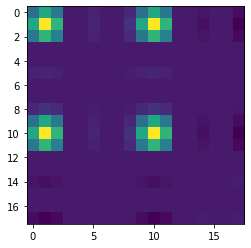

In [208]:
imshow(dm_conv)

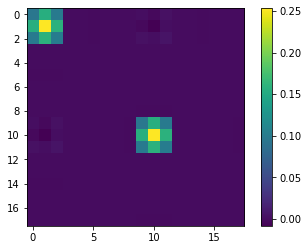

In [211]:
imshow(dm_init)
colorbar()

In [1]:
import pylibnxc
from pyscf import gto, scf, dft
import json
from ase.io import read, write
import numpy as np
import sys
from ase.units import Hartree, kcal, mol
kcalpmol = kcal/mol

In [104]:
def prepare_reaction(data, ref=None):
    xyzs = []
    for i, reactant in enumerate(data):
        a = data[reactant][0]
        a.info.update({'grid_level':1, 'sym':False, 'sc':False, 'reaction': 2 if i == 2 else 'reactant',
                      'reference_height': ref*kcalpmol/Hartree if i ==2 else None,'spin':a.info.get('multiplicity',1)-1})
        xyzs.append(a)
    return xyzs

In [105]:
with open('../data/bh_76_instructions.json','r') as file:
        instructions = json.load(file)
with open('../data/bh_76_dict.json','r') as file:
    xyz_dict = json.load(file)

basis = '6-311++G(3df,2pd)'
barrier_heights = []
reference_heights = []
systems = [0, 1, 57, 9]
reaction_atoms = [] 
for system in systems:
    inst = instructions[system]
    geometries = inst['setup']['reaction_geometries']
    xyz_data = {}
    for geom in geometries:
        xyz_data[geom] = read('../data/xyz/' + xyz_dict[geom[2:]],':')

    reaction_atoms+= prepare_reaction(xyz_data, inst['reference_value'])
    


In [106]:
from ase import Atoms

In [107]:
reaction_atoms += [Atoms('C', info={'spin':1, 'grid_level':1, 'sym':False, 'charge':1, 'reaction' : 'reactant', 'reference_height': None}),
Atoms('C', info={'spin':2, 'grid_level':1, 'sym':False, 'charge':0, 'reaction' : 1, 'reference_height': -259.7*kcalpmol/Hartree}),
Atoms('Li', info={'spin':0, 'grid_level':1, 'sym':False, 'charge':1, 'reaction' : 'reactant', 'reference_height': None}),
Atoms('Li', info={'spin':1, 'grid_level':1, 'sym':False, 'charge':0, 'reaction' : 1, 'reference_height': -124.34*kcalpmol/Hartree})]

In [108]:
reaction_atoms

[Atoms(symbols='H', pbc=False),
 Atoms(symbols='N2O', pbc=False),
 Atoms(symbols='HON2', pbc=False),
 Atoms(symbols='OH', pbc=False),
 Atoms(symbols='N2', pbc=False),
 Atoms(symbols='HON2', pbc=False),
 Atoms(symbols='OH', pbc=False),
 Atoms(symbols='CH3', pbc=False),
 Atoms(symbols='CH4O', pbc=False),
 Atoms(symbols='FH', pbc=False),
 Atoms(symbols='F', pbc=False),
 Atoms(symbols='HF2', pbc=False),
 Atoms(symbols='C', pbc=False),
 Atoms(symbols='C', pbc=False),
 Atoms(symbols='Li', pbc=False),
 Atoms(symbols='Li', pbc=False)]

In [109]:
from ase.io import read, write 

In [110]:
write('../data/haunshild_pbe_reaction.traj',read('../data/haunschild_pbe_radical.traj',':') + reaction_atoms)

In [111]:
write('../data/haunshild_scan_reaction.traj',read('../data/haunschild_scan_radical.traj',':') + reaction_atoms)

In [112]:
reaction_atoms[0].info

{'multiplicity': 2,
 'grid_level': 1,
 'sym': False,
 'sc': False,
 'reaction': 'reactant',
 'reference_height': None,
 'spin': 1}

In [101]:
[r.info['reference_height'] for r in reaction_atoms]

[None,
 None,
 0.02890793008677891,
 None,
 None,
 0.13261951167705296,
 None,
 None,
 0.012908171648451443,
 None,
 None,
 0.16920860069537955,
 None,
 -0.4138582934694864,
 None,
 -0.19814840281092005]

In [91]:
basis = '6-311++G(3df,2pd)'
mol = gto.M(atom='Li 0 0 0', basis=basis,spin=0,charge=1)
mol.verbose = 1
mf = dft.RKS(mol)
mf.xc = 'PBE'
mf.grids.level = 9
mf.kernel()


-7.255304970626048

In [30]:
from ase.units import kcal,mol, Hartree
kcalpmol = kcal/mol

In [31]:
(-37.79248985207391+37.36827197375319)*Hartree/kcalpmol

-266.20073763971834